# Projeto Rossmann Store Sales

Importação das Bibliotecas

In [4]:
! pip install inflection boruta scikit-optimize 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.7 MB/s eta 0:00:00


In [1]:
import pandas as pd
import inflection
import math
import calendar
import numpy as np
import datetime
import scipy.stats as ss
from itertools import product
import pickle

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from boruta import BorutaPy

from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import TimeSeriesSplit


### Helper Functions

In [24]:
def jupyter_settings():
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from IPython.display import display, HTML

    # Matplotlib and Seaborn configuration
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    sns.set()

    # Pandas display options
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)


In [25]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat) )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )

In [26]:
def cramer_v (x, y):
    """
    Calculates Cramér's V statistic for categorical-categorical association,
    with bias correction as proposed by Bergsma (2013).

    Parameters:
    - x: categorical variable (Pandas Series)
    - y: categorical variable (Pandas Series)

    Returns:
    - Cramér's V value (float) indicating the strength of association (0 = no association, 1 = perfect association)
    """
    cm = pd.crosstab(x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)


    v = np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)  ) )

    return v

In [27]:
def generate_matrix_cramer_v(df, cols):
    """
    Generates a Cramér's V matrix for all combinations of categorical columns.

    Parameters:
    - df: DataFrame containing the data.
    - colunas: list with the names of the categorical columns.

    Returns:
    - DataFrame with the Cramér's V matrix.
    """

    matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for col1, col2 in product(cols, repeat=2):
        matrix.loc[col1, col2] = cramer_v(df[col1], df[col2])

    return matrix

In [28]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1 ) ):
        if verbose:
            print('\n KFold: {}' .format(k))
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        #filter dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        #training and validantion dataset
        x_train_kfold = training.drop(['date', 'sales'], axis=1)
        y_train_kfold = training['sales']

        x_validation_kfold = validation.drop(['date', 'sales'], axis=1)
        y_validation_kfold = validation['sales']

        #model
        model_trained = model.fit(x_train_kfold, y_train_kfold)
        #prediction
        yhat_lr = model_trained.predict(x_validation_kfold)
        #performance
        model_result = ml_error(model_name, np.expm1(y_validation_kfold), np.expm1(yhat_lr))

        #store performance of each kold iteration
        mae_list.append(model_result['MAE'])
        mape_list.append(model_result['MAPE'])
        rmse_list.append(model_result['RMSE'])

    results = pd.DataFrame( {'Model Name': model_name,
                             'MAE CV':  np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                             'MAPE CV':  np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                             'RMSE CV':  np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)} , index=[0] )

    return results

## Data Description

In [29]:
import os

ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'projeto rossman', '..', '..'))
train_path = os.path.join(ROOT_PATH, 'datasets', 'train.csv')
store_path = os.path.join(ROOT_PATH, 'datasets', 'store.csv')


df_sales_raw = pd.read_csv(train_path, low_memory=False)
df_store_raw = pd.read_csv(store_path, low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

### Rename Columns

In [30]:
df1 = df_raw.copy()

In [31]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map ( snakecase, cols_old ))

df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### Data Dimensions

In [32]:
print('Number of Rows: {}'. format(df1.shape[0]))

print('Number of Cols: {}'. format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


### DataTypes


In [33]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [34]:
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')

In [35]:
df1 = df1.dropna(subset=['date'])

### Check NA

In [36]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### Fillout NA

In [37]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 2000000.0 if pd.isna(x) else x
)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(
    lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'],
    axis=1
)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'],
    axis=1
)

# promo2_since_week
df1['date'] = pd.to_datetime(df1['date'])
df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].isocalendar()[1] if pd.isna(x['promo2_since_week']) else x['promo2_since_week'],
    axis=1
)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'],
    axis=1
)

In [38]:
#promo_interval
month = {i: calendar.month_abbr[i] for i in range(1, 13)}

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map(month)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [39]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change Type

In [40]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [41]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## Descriptive Statistical

In [42]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [43]:
num_attributes.sample(10)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
835856,392,3,5766,621,1,0,0,2120.0,6,2013,0,24,2013,0
665397,528,2,8125,802,1,0,0,20620.0,11,2013,1,37,2009,0
70480,236,5,9191,1064,1,0,0,1000.0,11,2007,0,22,2015,0
688319,35,2,8797,665,1,1,1,7660.0,10,2000,1,1,2012,1
787155,751,5,3423,461,1,0,1,650.0,10,2006,0,30,2013,0
497538,1034,6,2976,275,1,0,0,13750.0,4,2015,0,15,2014,0
357198,249,7,0,0,0,0,0,18010.0,9,2014,0,34,2014,0
101725,261,5,0,0,0,1,0,15340.0,4,2015,1,39,2009,0
599121,37,5,7893,879,1,1,0,4230.0,12,2014,0,2,2014,0
146937,873,7,0,0,0,0,0,2040.0,11,2008,0,12,2015,0


In [44]:
cat_attributes.sample(10)

,state_holiday,store_type,assortment,promo_interval,month_map
970906,0,d,c,0,Feb
625290,0,d,a,0,Dec
920018,b,a,c,0,Mar
745109,0,a,c,0,Sep
885643,0,c,c,0,Apr
849126,0,a,a,0,May
669067,0,a,a,0,Nov
835709,0,a,c,0,Jun
894799,0,a,a,0,Apr
735493,0,d,a,0,Sep


##### Numerical Attributes

In [45]:
#Central Tendency - Mean, Median or Mode
c_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
c_median = pd.DataFrame(num_attributes.apply(np.median)).T
#Dispersion - std, min, max, range, skew,  kurtosis
d_std = pd.DataFrame(num_attributes.apply(np.std)).T
d_min = pd.DataFrame(num_attributes.apply(np.min)).T
d_max = pd.DataFrame(num_attributes.apply(np.max)).T
d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

metrics = pd.concat([d_min, d_max, d_range, c_mean, c_median, d_std, d_skew, d_kurtosis]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


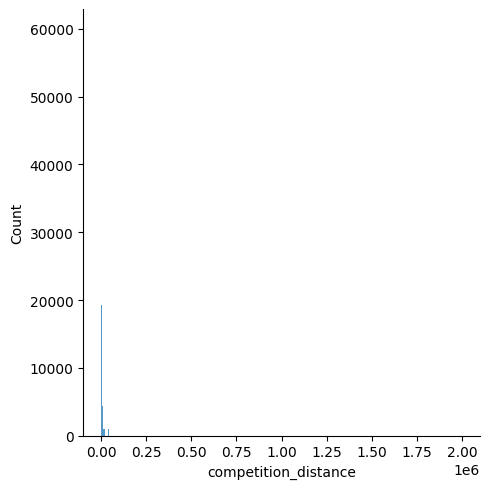

In [46]:
sns.displot(df1['competition_distance'])

#### Categorical Attributes

In [47]:
cat_attributes.apply(lambda x: x.unique(). shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='state_holiday', ylabel='sales'>

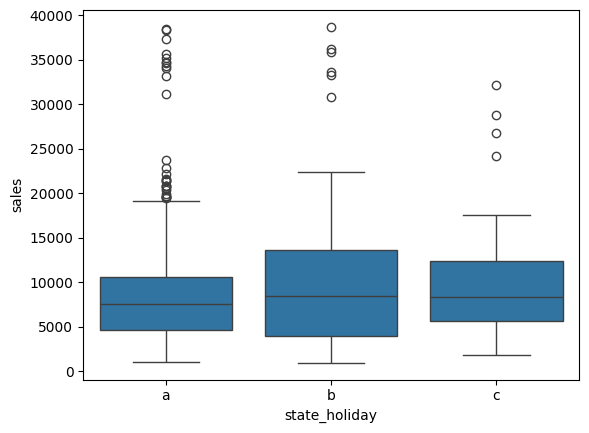

In [48]:
aux1 = df1.loc[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

sns.boxplot(x='state_holiday', y='sales', data=aux1)

<Axes: xlabel='store_type', ylabel='sales'>

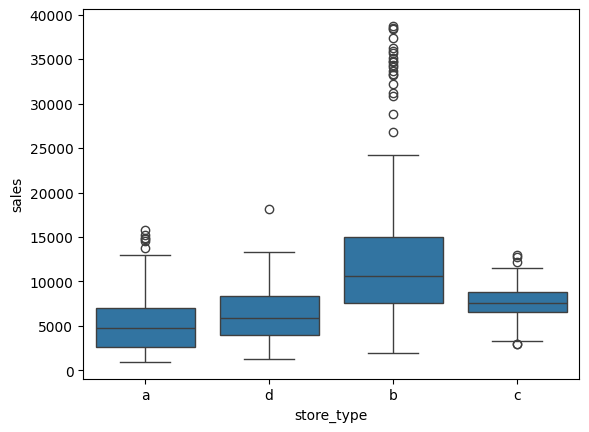

In [49]:
sns.boxplot(x='store_type', y='sales', data=aux1)

<Axes: xlabel='assortment', ylabel='sales'>

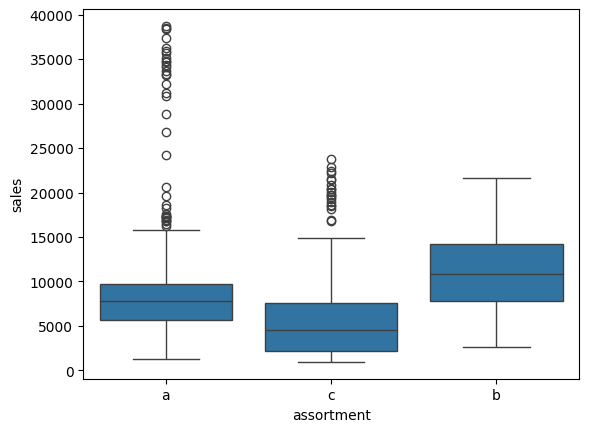

In [50]:
sns.boxplot(x='assortment', y='sales', data=aux1)

## Feature Engineer

### Hipóteses

1. Lojas com maior sortimento deveriam vender mais.  
2. Lojas com competidores mais próximos deveriam vender menos.  
3. Lojas com competidores a mais tempo deveriam vender mais.  
4. Lojas com promoções ativas por mais tempo deveriam vender mais.  
5. Lojas com mais dias de promoção deveriam vender mais.  
6. Lojas com mais promoções consecutivas deveriam vender mais.  
7. Lojas com mais promoções consecutivas deveriam vender mais.  
8. Lojas abertas durante o feriado de Natal deveriam vender mais.  
9. Lojas deveriam vender mais ao longo dos anos.  
10. Lojas deveriam vender mais no segundo semestre do ano.  
11. Lojas deveriam vender mais depois do dia 10 de cada mês.  
12. Lojas deveriam vender menos aos finais de semana.  
13. Lojas deveriam vender menos durante os feriados escolares.


In [51]:
df2 = df1.copy()

### Feature Engineer

In [52]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [53]:

#competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime(year=x['competition_open_since_year'],
                       month=x['competition_open_since_month'],
                       day=1),
    axis=1
)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)


In [54]:
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

In [55]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## Filtering Variable

In [56]:
df3 = df2.copy()

#### Filter Lines

In [57]:
df3 = df3.loc[(df3['open'] != 0) & (df3['sales'] > 0)]

#### Filter Cols

In [58]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

## Exploratory Data Analysis (EDA)

Objectives of EDA:

* Better understand the business
* Validate business hypotheses (Insights)
* Identify the best variables to the model

Tipos de Análise EDA:

* Univariate Analysis
* Bivariate Analysis
* Multivariate Analysis

In [60]:
df4 = df3.copy()

### Univariate Analysis

#### Response Variable

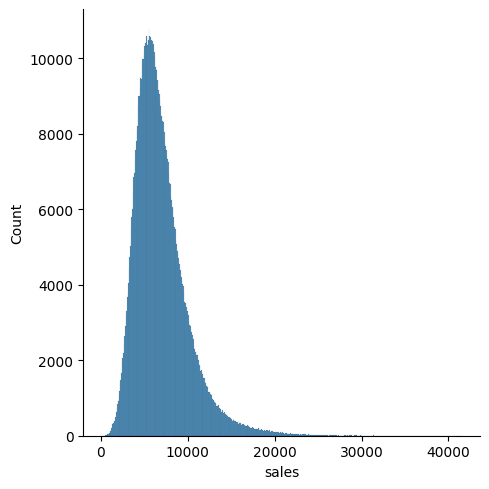

In [61]:
sns.displot(df4['sales'])

#### Numerical Variable

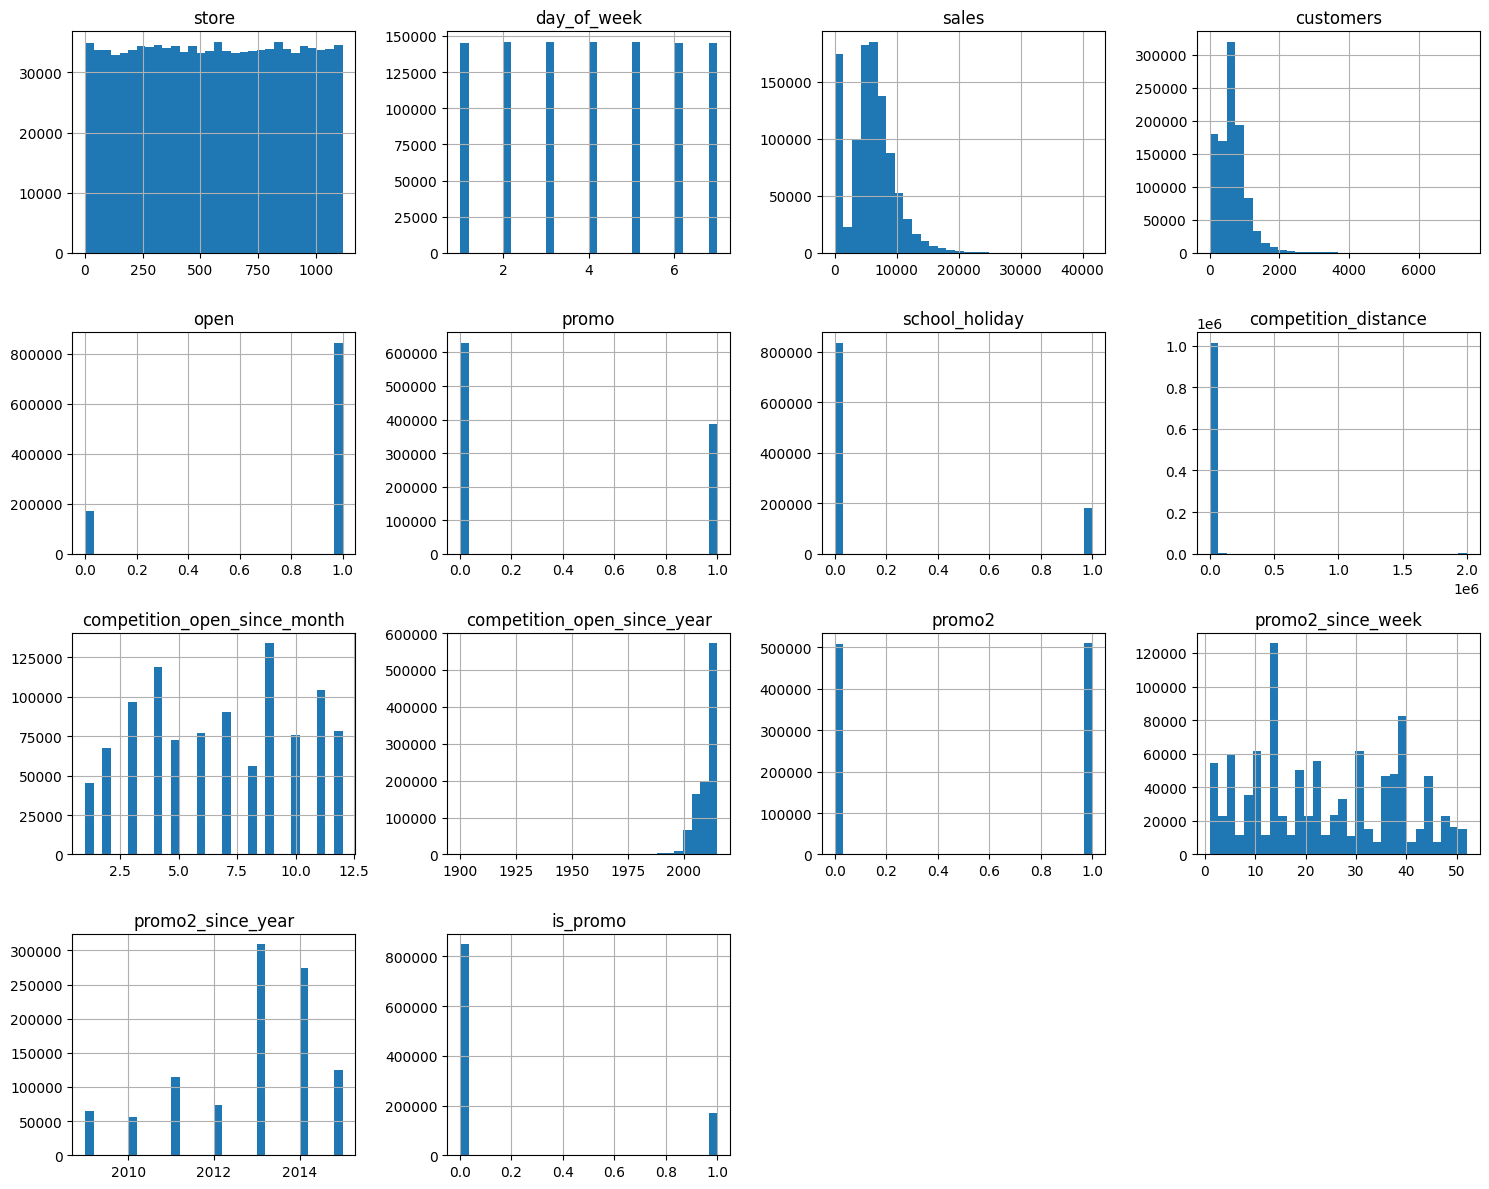

In [62]:
num_attributes.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

#### Categorical Variables

In [63]:
df4['state_holiday'].value_counts()

state_holiday
regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: count, dtype: int64

<Axes: xlabel='sales', ylabel='Density'>

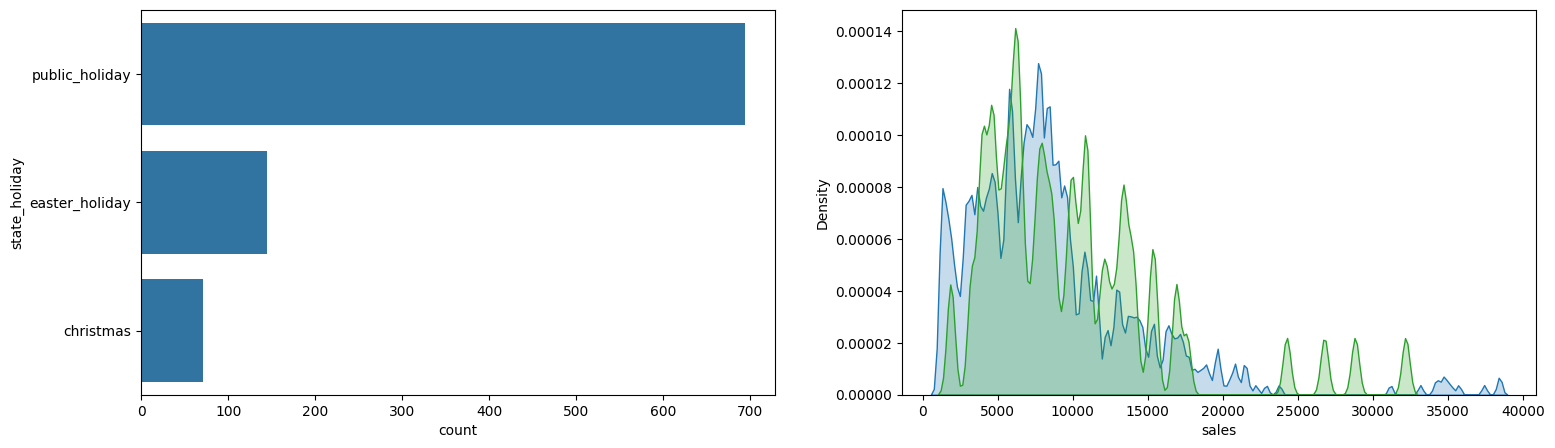

In [64]:
#state_holiday
#regular day is most common

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
days = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(days['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True, bw_adjust=0.1)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_day']['sales'], label='easter_holiday', fill=True, bw_adjust=0.1)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True, bw_adjust=0.1)

In [65]:
df4['store_type'].value_counts()

store_type
a    457042
d    258768
c    112968
b     15560
Name: count, dtype: int64

<Axes: xlabel='sales', ylabel='Density'>

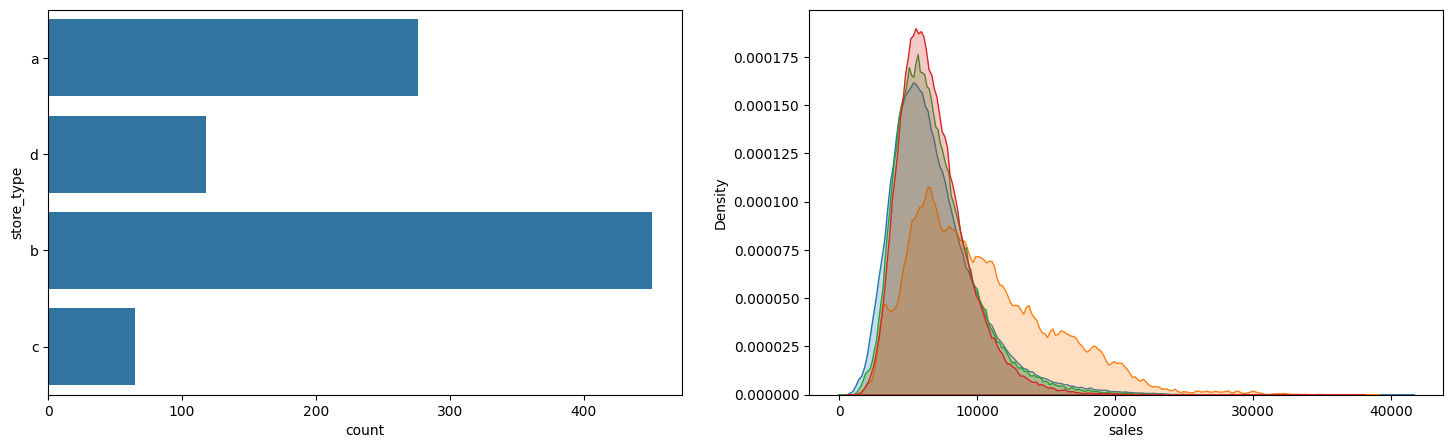

In [66]:
#store_type
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.countplot(days['store_type'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True, bw_adjust=0.2)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True, bw_adjust=0.2)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True, bw_adjust=0.2)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True, bw_adjust=0.2)

<Axes: xlabel='sales', ylabel='Density'>

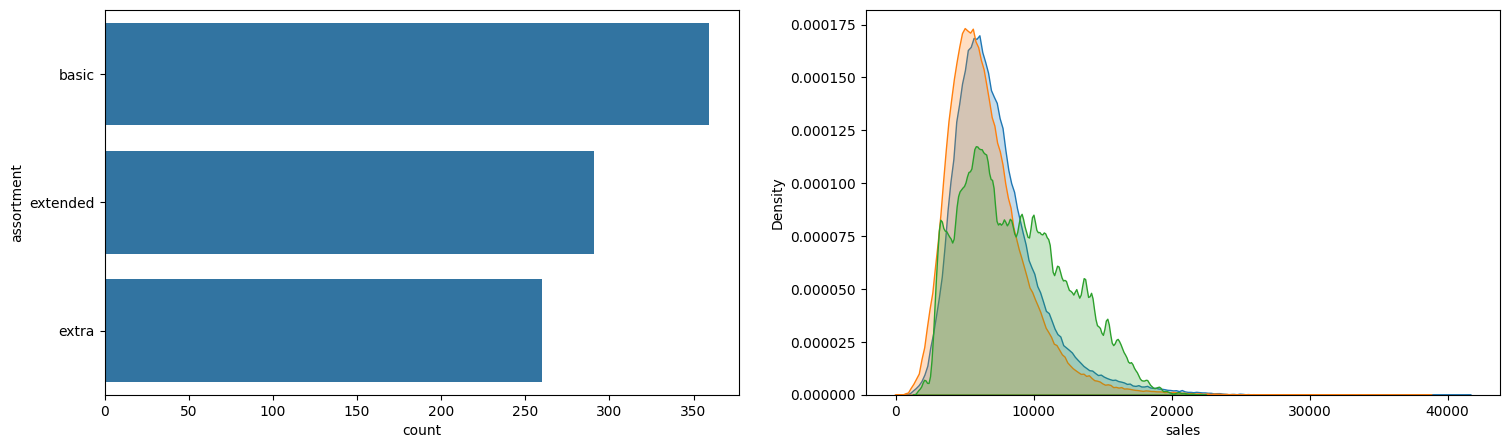

In [67]:
#assortment
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.countplot(days['assortment'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True, bw_adjust=0.2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True, bw_adjust=0.2)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True, bw_adjust=0.2)

### Bivariate Analysis

##### H1. STORES WITH A WIDER ASSORTMENT SHOULD SELL MORE

FALSE Stores with a wider assortment sell less.

<Axes: xlabel='year_week'>

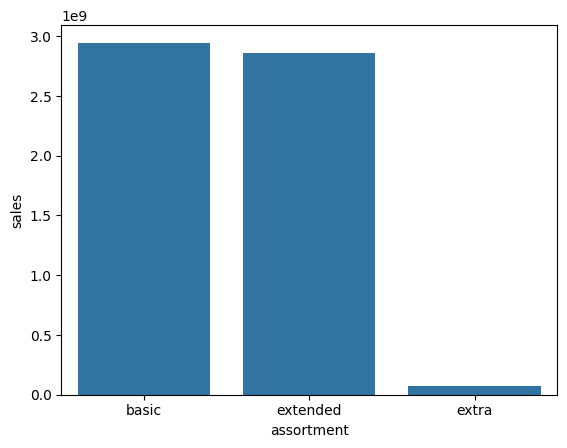

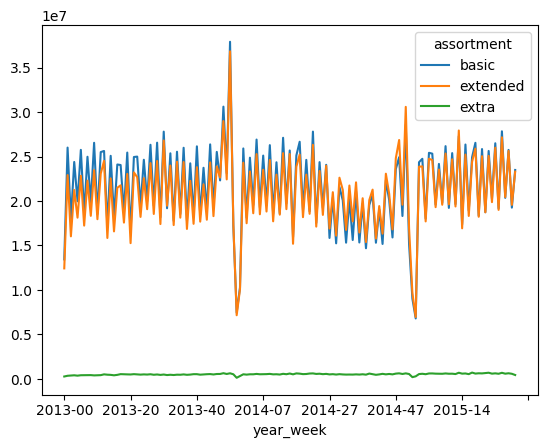

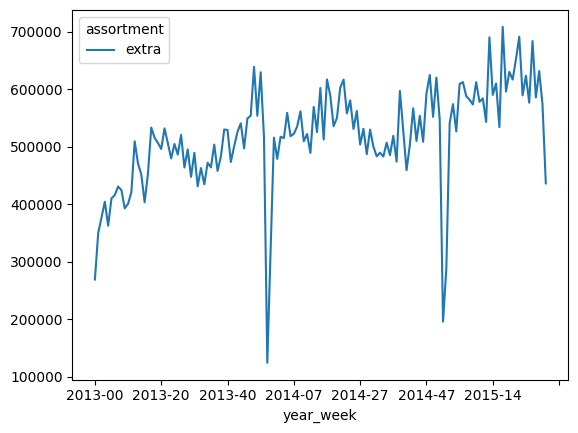

In [68]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

##### H2. STORES WITH CLOSER COMPETITORS SHOULD SELL LESS

FALSE Stores with closer competitors sell more.

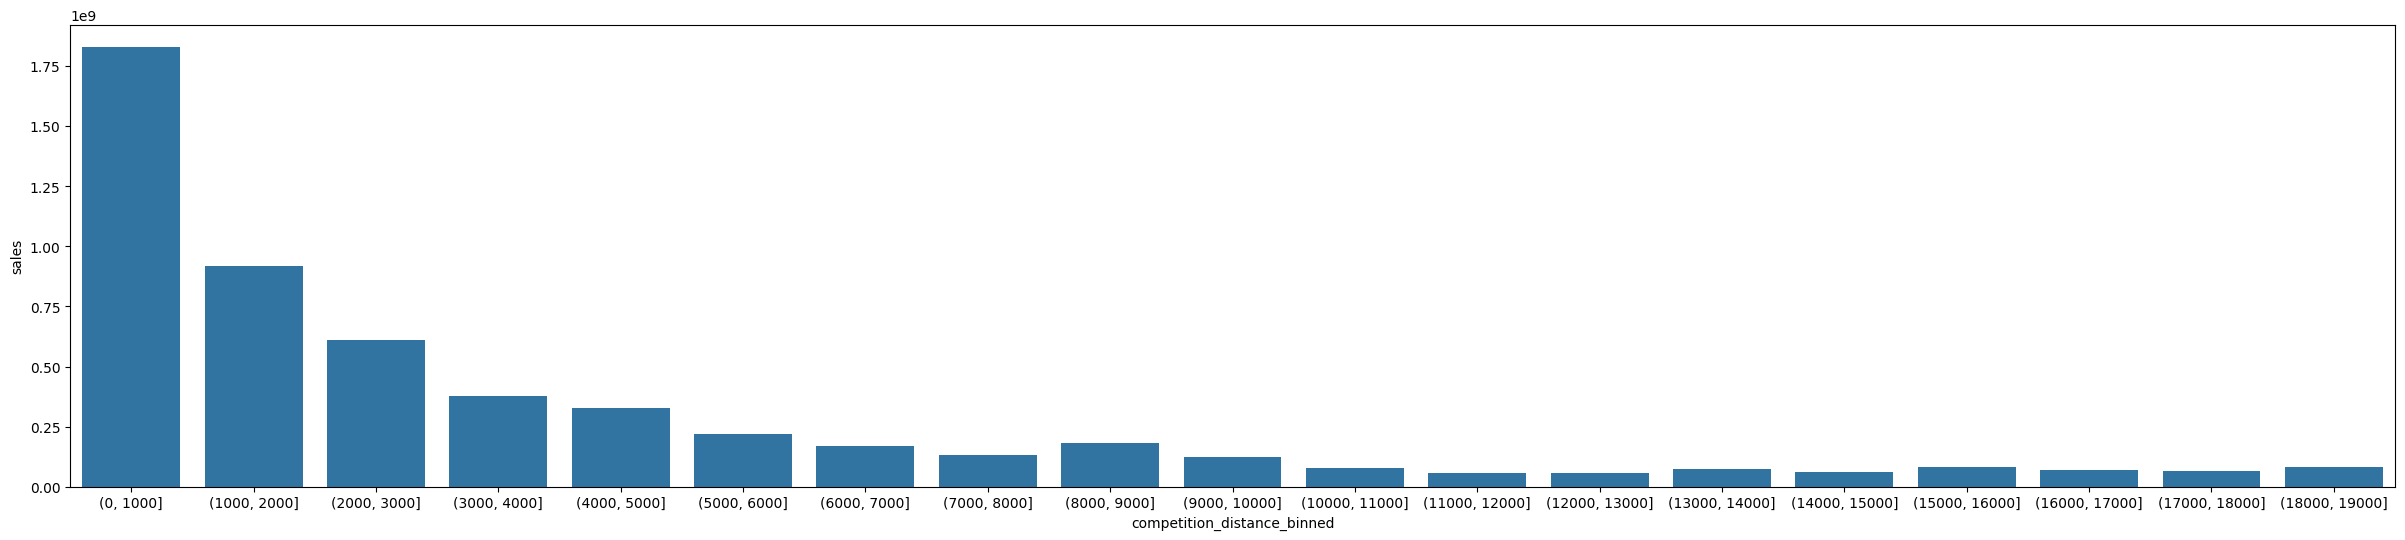

In [69]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list( np.arange(0,20000, 1000) )

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned', observed=False).sum().reset_index()

plt.figure(figsize=(30, 6))
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

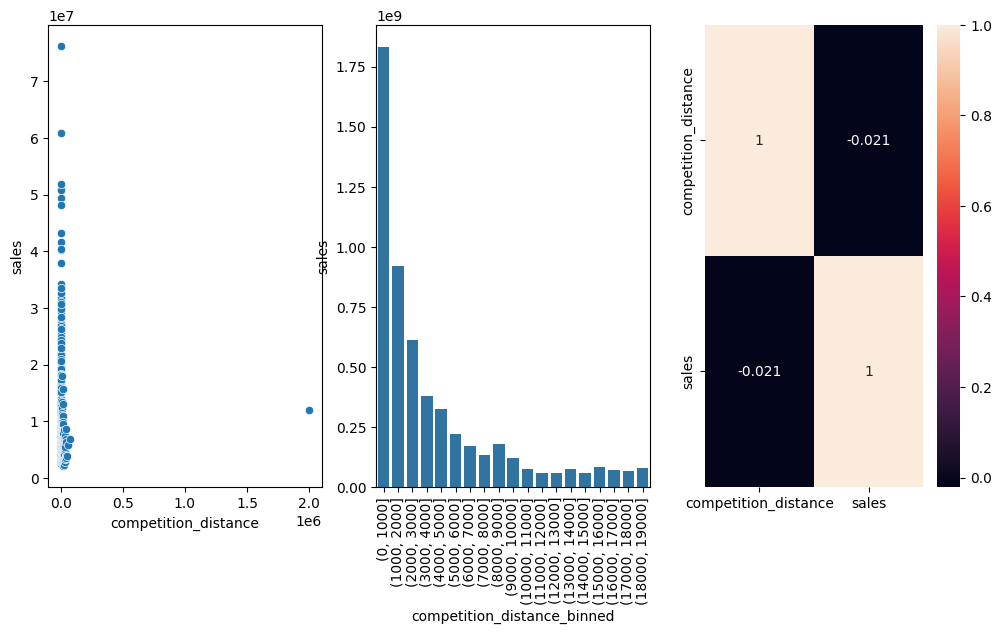

In [70]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(12, 6))
plt.subplot( 1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);
plt.subplot( 1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot( 1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### H3. STORES WITH LONGER-STANDING COMPETITORS SHOULD SELL MORE

FALSE Stores with longer-standing competitors sell less.

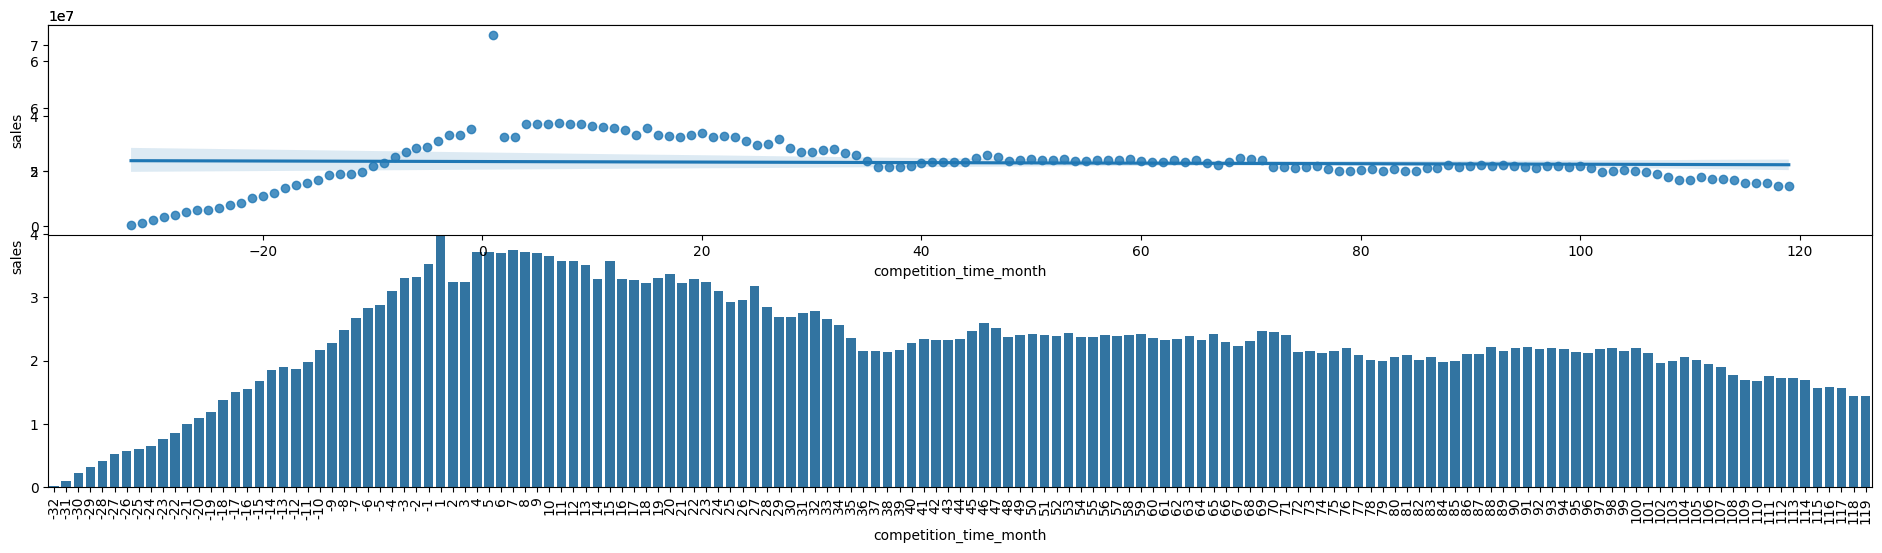

In [71]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]


plt.figure(figsize=(80, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(2, 3, 1)
sns.regplot(x='competition_time_month', y='sales', data=aux2);


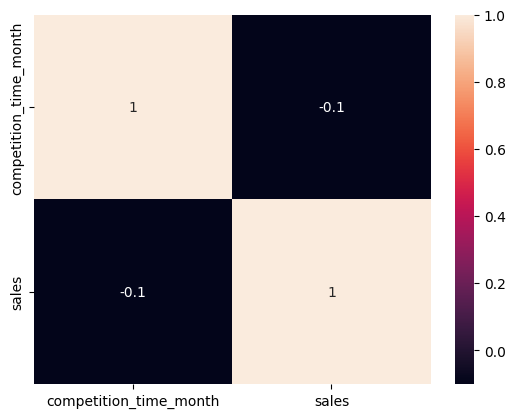

In [72]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### H4. STORES WITH PROMOTIONS ACTIVE FOR LONGER PERIODS SHOULD SELL MORE.

FALSE, Stores with active promotions for a longer period sell less after a certain promotion duration.

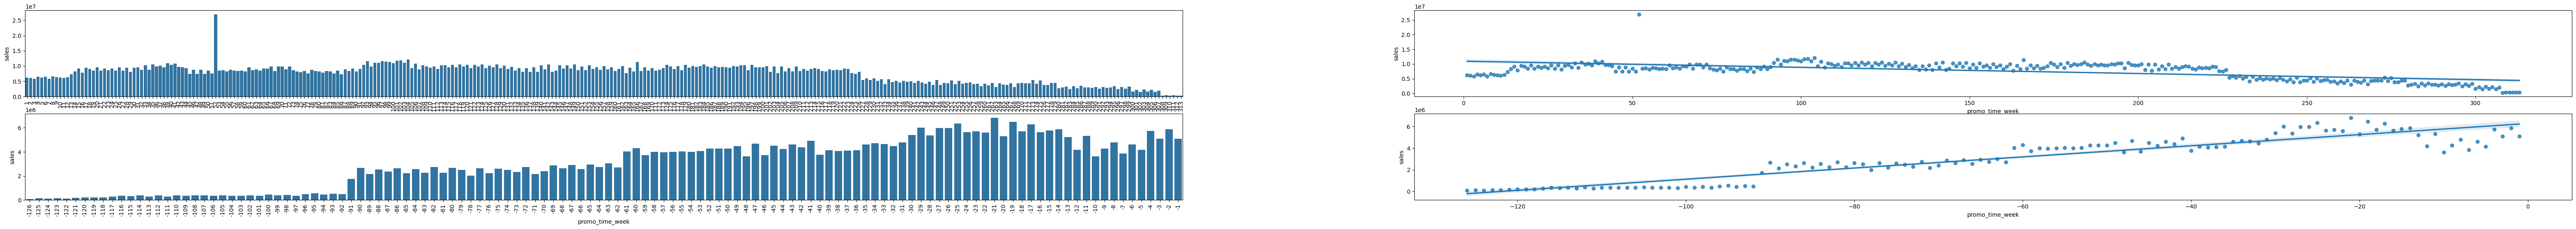

In [73]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(80, 6))
plt.subplot(2,2,1)
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(2,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2,2,3)
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(2,2,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);


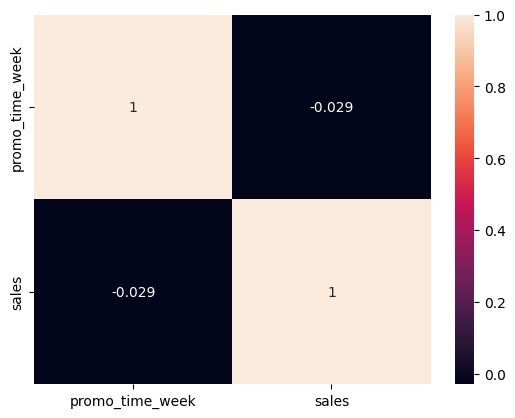

In [74]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### <s>H5. LOJAS COM MAIS DIAS DE PROMOÇÃO DEVERIAM VENDER MAIS</s>

##### H6. STORES WITH MORE CONSECUTIVE PROMOTIONS SHOULD SELL MORE

FALSE, Stores with extended promotions sell less

In [75]:
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

aux1

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


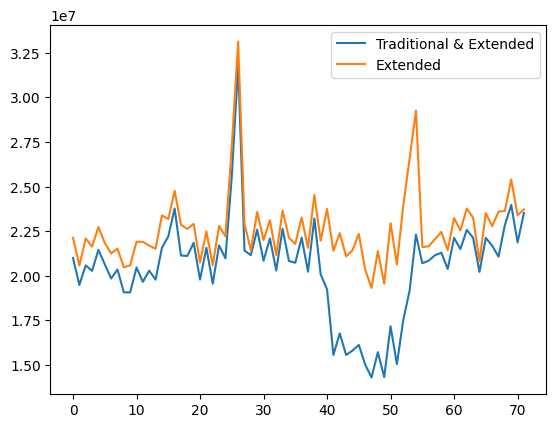

In [76]:

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)]

aux1 = aux1[['year_week', 'sales']].groupby('year_week').sum().reset_index()

ax = aux1.plot()


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)]

aux2 = aux2[['year_week', 'sales']].groupby('year_week').sum().reset_index()

aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extended', 'Extended'])

##### H7. STORES OPEN ON CHRISTMAS SHOULD SELL MORE
False, stores sell less at Christmas compared to other holidays.

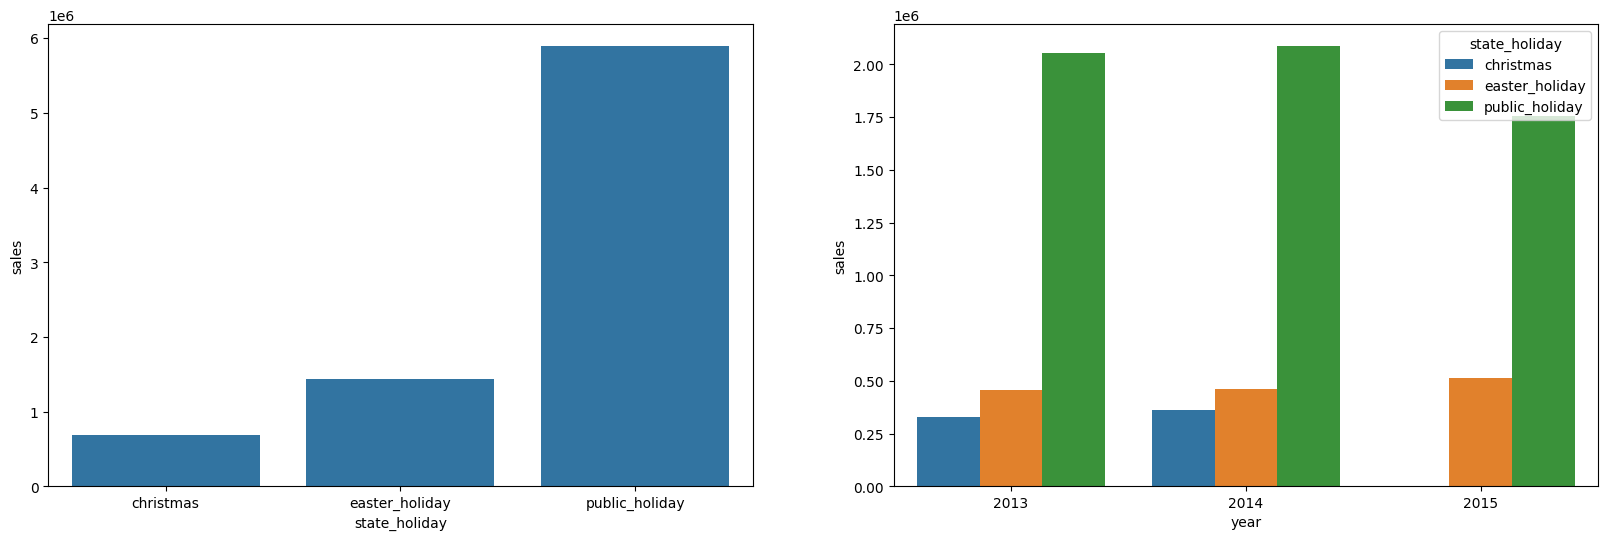

In [77]:
aux1 = df4[(df4['state_holiday'] != 'regular_day')]

plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

sns.barplot(data=aux2, x='state_holiday', y='sales');

plt.subplot(1,2,2)
aux3 = aux1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

sns.barplot(data=aux3, x='year', y='sales', hue='state_holiday');

#####  H8. STORES SHOULD SELL MORE OVER THE YEARS

False, stores sell less over the years

<Axes: >

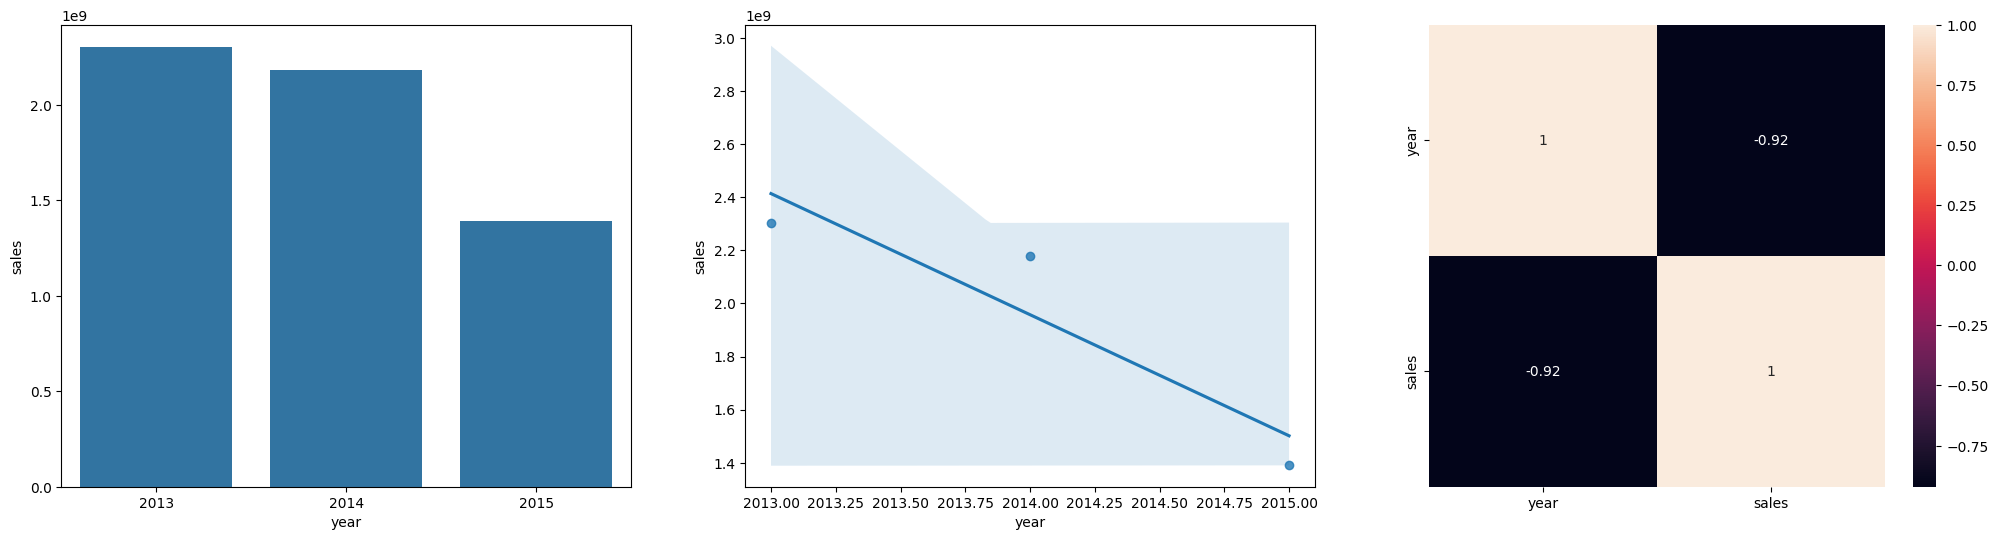

In [78]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

##### H9. STORES SHOULD SELL MORE IN THE SECOND HALF OF THE YEAR

False. Stores sell less in the second half of the year

<Axes: >

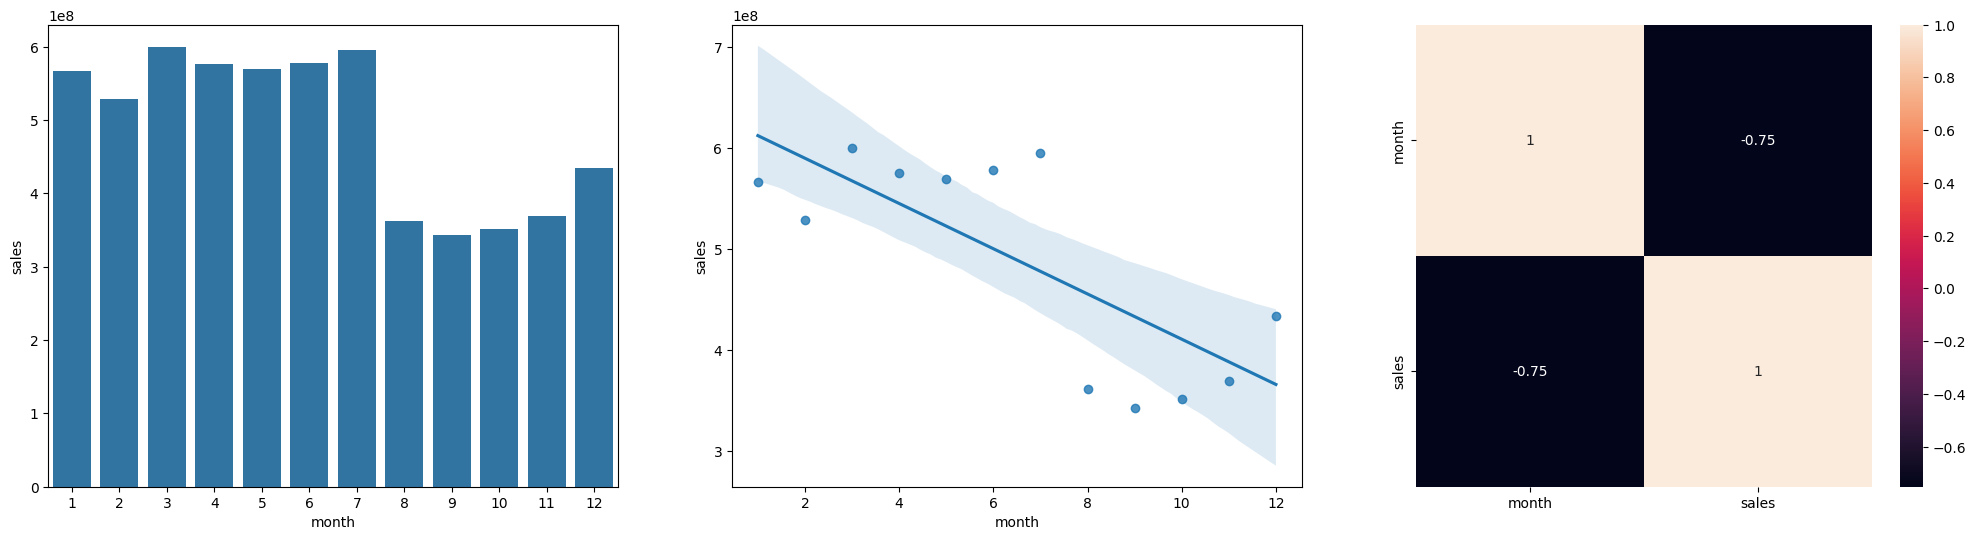

In [79]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

##### H10. STORES SHOULD SELL MORE AFTER THE 10TH DAY OF EACH MONTH

True. Stores sell more after the 10th

<Axes: >

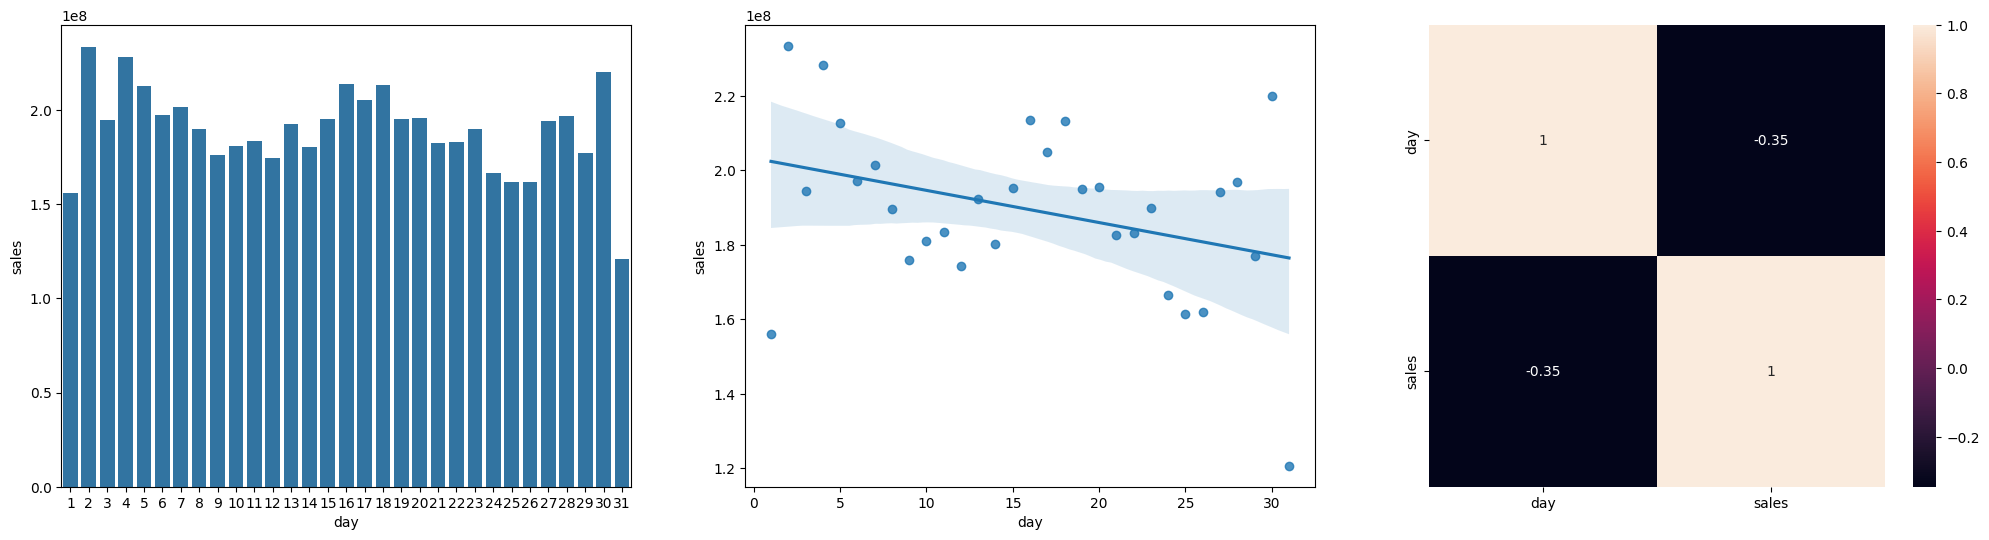

In [80]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

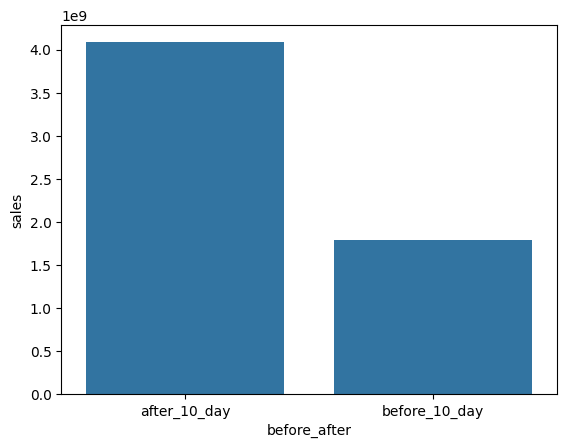

In [81]:
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_day' if x < 10 else 'after_10_day' )

aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

sns.barplot(x='before_after', y='sales', data=aux2);

##### H11. STORES SHOULD SELL LESS ON WEEKENDS

True. Stores sell more during the week

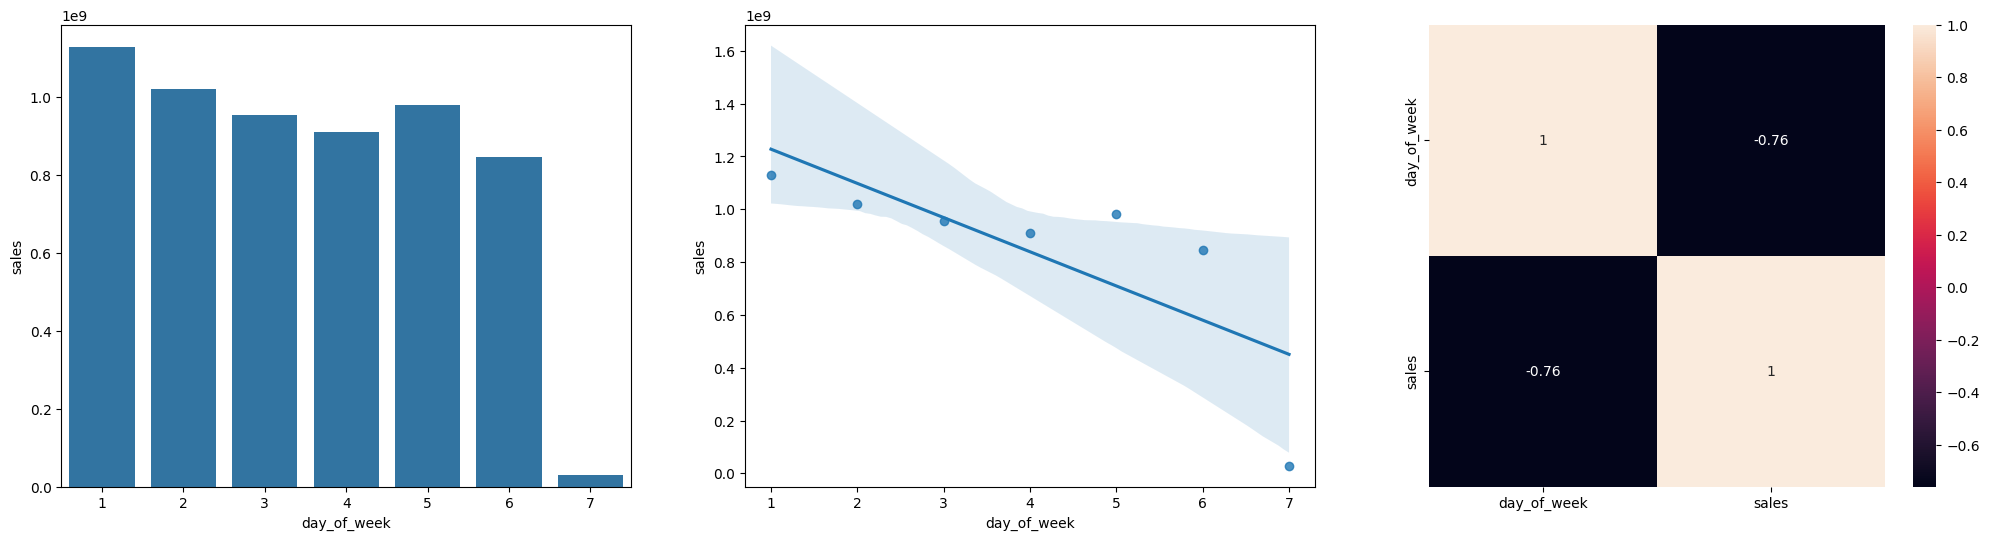

In [82]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

##### H12. STORES SHOULD SELL LESS DURING SCHOOL HOLIDAYS.

True, Stores sell more on days that are not school holidays, except august

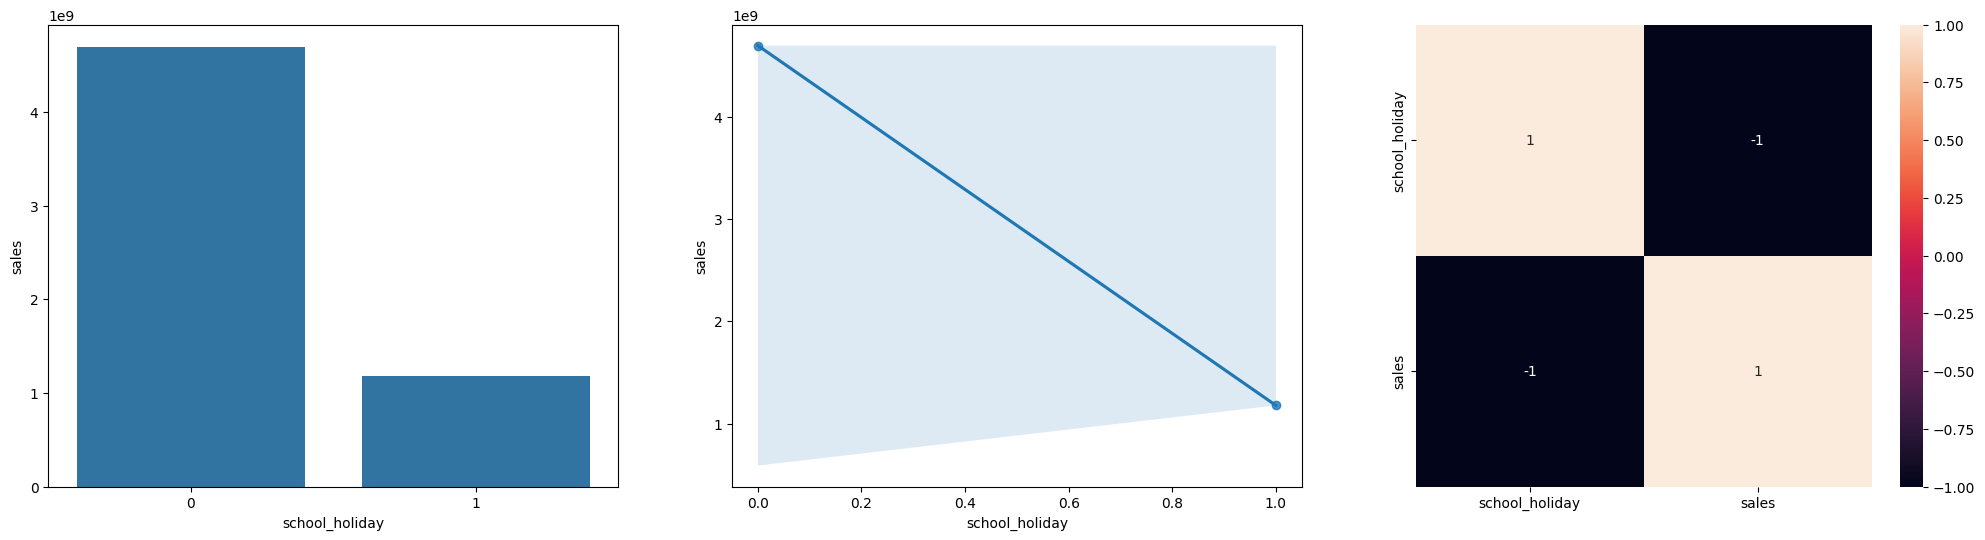

In [83]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

In [84]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


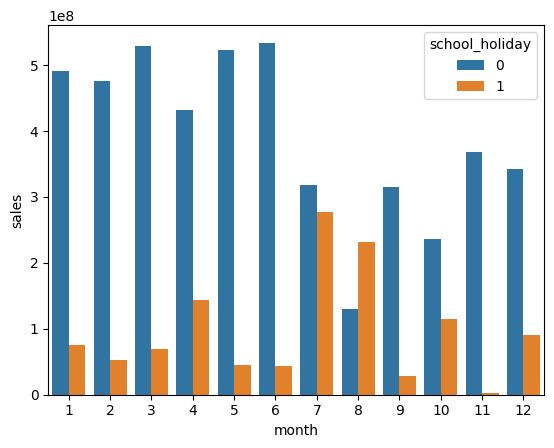

In [85]:
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### Multivariate Analysis

##### Numeric Attributes

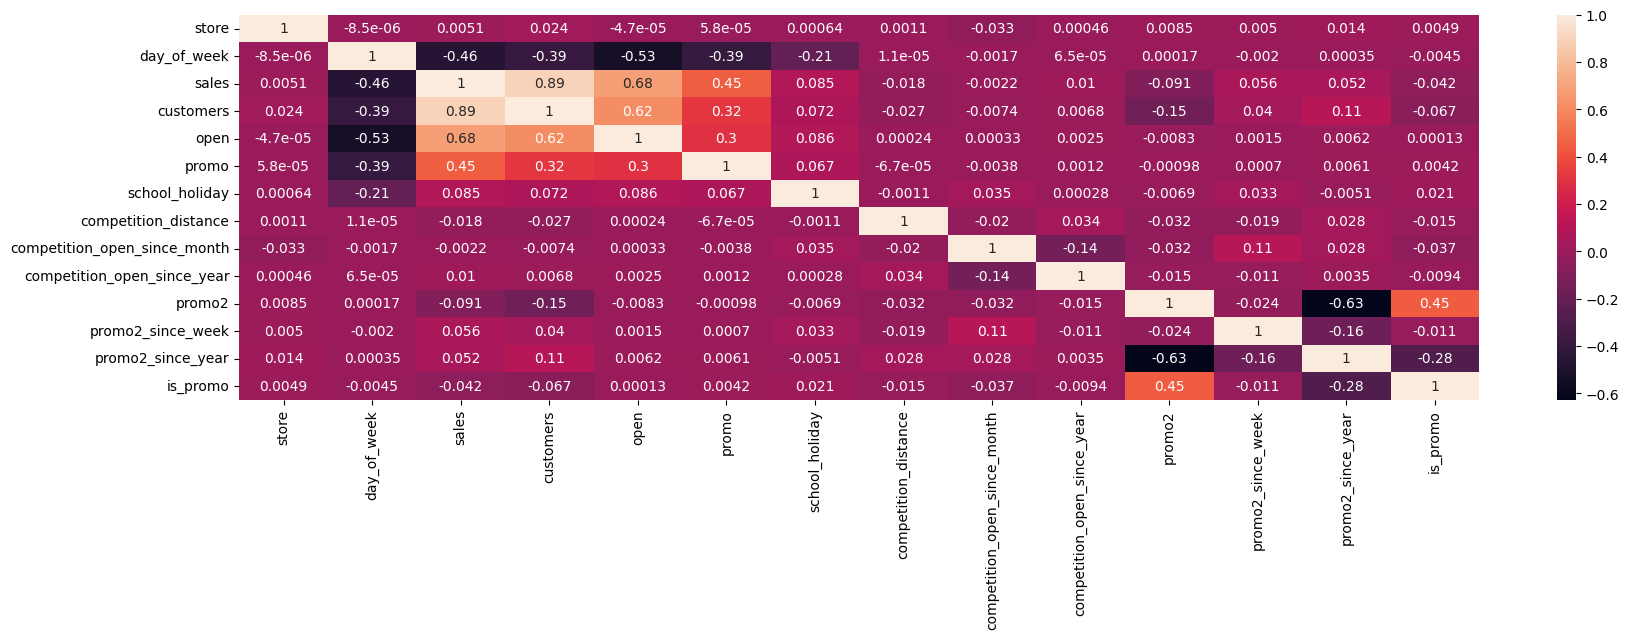

In [86]:
corr = num_attributes.corr(method='pearson')

plt.figure(figsize=(20,5))
sns.heatmap(corr, annot=True);

##### Categorical Attributes

In [87]:
categorical_attributes = df4.select_dtypes( include='object')

<Axes: >

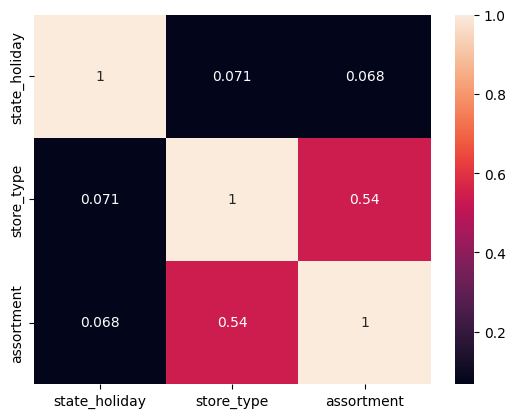

In [88]:
categorical_columns = ['state_holiday', 'store_type', 'assortment']
matrix_cramer = generate_matrix_cramer_v(categorical_attributes, categorical_columns)

sns.heatmap(matrix_cramer, annot=True)

In [89]:
#Analysis thge best features from  Boruta with the Hipotesis
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Baixa'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Media'],
       ['H5', 'Falsa', 'Media'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Media'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Media
H4           Falsa        Media
H5           Falsa        Media
H6           Falsa        Baixa
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## Data Preparation


In [90]:
df5 = df4.copy()

df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

#### Rescaling

In [91]:
df5[df5.select_dtypes(include=['int', 'uint']).columns] = df5.select_dtypes(include=['int', 'uint']).astype('int64')


df_numerical = df5.select_dtypes(include=['int64', 'float64'])

df_numerical.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


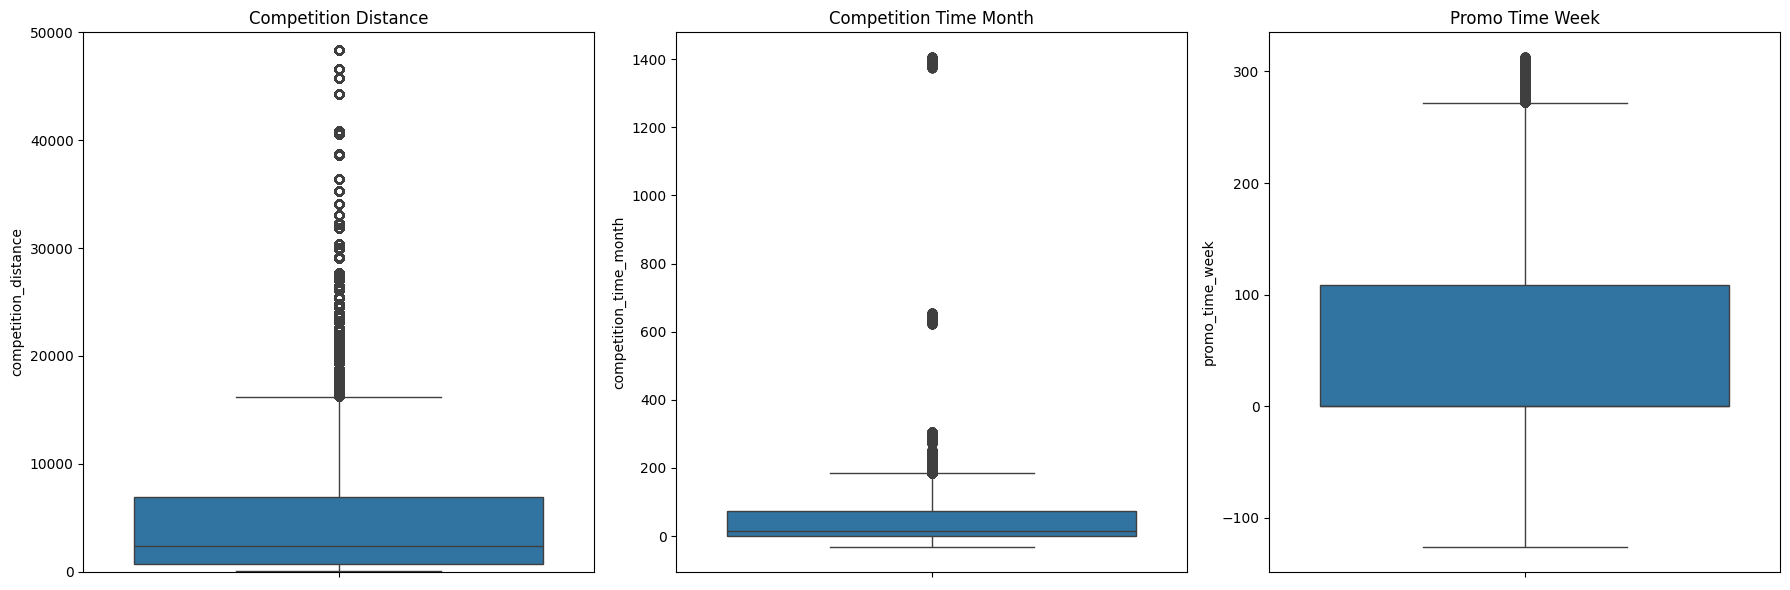

In [92]:
variaveis = ['competition_distance', 'competition_time_month', 'promo_time_week']
limites_y = [50000, None, None]  # Você pode ajustar os limites se quiser

# Cria a figura com 1 linha e 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, var in enumerate(variaveis):
    sns.boxplot(y=df5[var], ax=axes[i])
    axes[i].set_title(var.replace('_', ' ').title())
    if limites_y[i] is not None:
        axes[i].set_ylim(0, limites_y[i])

plt.tight_layout()

In [93]:
rs = RobustScaler()
mms = MinMaxScaler()

ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'projeto rossman', '..', '..'))

#Applying Robust Scaler to features without strong outliers
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open(os.path.join(ROOT_PATH, 'parameter', 'competition_distance_scaler.pkl'), 'wb'))
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open(os.path.join(ROOT_PATH, 'parameter', 'competition_time_month_scaler.pkl'), 'wb'))

#Applying Min-Max Scaler to features without strong outliers
df5['promo_time_week'] = rs.fit_transform( df5[['promo_time_week']].values )
pickle.dump(rs, open(os.path.join(ROOT_PATH, 'parameter', 'promo_time_week_scaler.pkl'), 'wb'))


df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open(os.path.join(ROOT_PATH, 'parameter', 'year_scaler.pkl'), 'wb'))


#### Transformation

##### Enconding

In [94]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.000000
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,2.559633
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,2.073394
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.000000
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.000000


In [95]:
# state_holiday
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [97]:
# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

pickle.dump(le, open(os.path.join(ROOT_PATH, 'parameter', 'store_type_scaler.pkl'), 'wb'))


In [98]:
# assortment
oe = OrdinalEncoder()
df5['assortment'] = oe.fit_transform(df5[['assortment']]).astype('int64')+1

pickle.dump(oe, open(os.path.join(ROOT_PATH, 'parameter', 'assortment_scaler.pkl'), 'wb'))


##### Response Variable Transformation

In [99]:
df5['sales'] = np.log1p( df5['sales'])

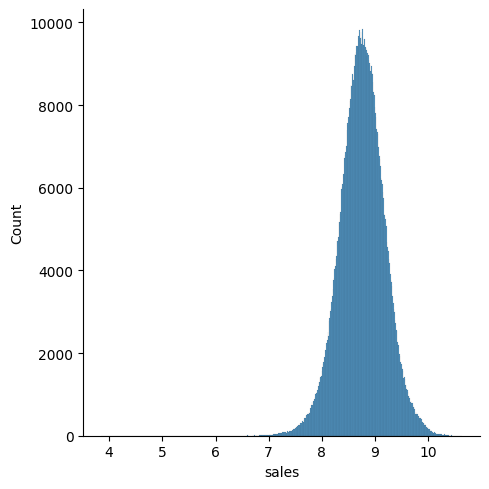

In [100]:
sns.displot(df5['sales'])

##### Nature Transformation

In [101]:
#cyclic variables
#day_of_week
df5['day_of_week_sin'] =  df5['day_of_week'].apply( lambda x: np.sin ( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] =  df5['day_of_week'].apply( lambda x: np.cos ( x * ( 2. * np.pi/7 ) ) )
#month
df5['month_sin'] =  df5['month'].apply( lambda x: np.sin ( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] =  df5['month'].apply( lambda x: np.cos ( x * ( 2. * np.pi/12 ) ) )
#day
df5['day_sin'] =  df5['day'].apply( lambda x: np.sin ( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] =  df5['day'].apply( lambda x: np.cos ( x * ( 2. * np.pi/30 ) ) )
#week_of_year
df5['week_of_year_sin'] =  df5['week_of_year'].apply( lambda x: np.sin ( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] =  df5['week_of_year'].apply( lambda x: np.cos ( x * ( 2. * np.pi/52 ) ) )

In [102]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## Feature Selection

In [103]:
df6 = df5.copy()

In [ ]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


#### Split Dataset into training and test dataset

In [104]:
cols_drop = ['day','month', 'week_of_year','day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [105]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [106]:
#Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

##### Boruta as Feature Selector

In [ ]:
'''X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

rf = RandomForestRegressor(n_jobs=-1)

boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)'''

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	8


##### Best Features from Boruta

In [ ]:
'''cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train.fs.columns, cols_selected_boruta ) )'''

In [ ]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos']

##### Manual Feature Selection (Based Boruta and Hypotheses)

In [107]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        #columns to add for prediction
                        #'date',
                        #'sales'
                        ]

## Machine Learning Models

In [108]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [112]:
cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend(['date', 'sales'])

#Time Seires Data Preparation
x_training = X_train[cols_selected_boruta_full]

##### Average Model (Base Model for Comparison)

In [ ]:
aux1 =x_test.copy()
aux1['sales'] =  y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


##### Linear Regression Model

In [ ]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1857.720976,0.291125,2664.26976


##### Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)

In [ ]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.08 +/- 295.25,0.3 +/- 0.02,2951.66 +/- 467.44


##### Linear Regression Regularized Model - Lasso

In [ ]:
#model
ls = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_ls = ls.predict(x_test)

#performance
ls_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lr))
ls_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1857.720976,0.291125,2664.26976


##### Linear Regression Regularized Model - Lasso - Cross Validation

In [ ]:
ls_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', ls)

In [ ]:
ls_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2119.08 +/- 342.14,0.29 +/- 0.01,3062.0 +/- 505.05


##### Random Forest Regressor

In [ ]:
#model
x_train_rf = x_train.astype('float32')
y_train_rf = y_train.astype('float32')
x_test_rf = x_test.astype('float32')


rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=1).fit(x_train_rf, y_train_rf)

#prediction
yhat_rf = rf.predict(x_test_rf)

#performance
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,684.591343,0.100855,1019.341381


##### Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf)

In [ ]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,845.2 +/- 221.18,0.12 +/- 0.02,1270.77 +/- 326.48


##### XGBoost Regressor

In [ ]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            #n_estimator=50,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            ).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBRegressor', np.expm1(y_test), np.expm1(yhat_rf))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,684.591343,0.100855,1019.341381


##### XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)

In [ ]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1860.28 +/- 290.91,0.25 +/- 0.01,2685.06 +/- 429.22


##### Compare Model's Performance (Single Performance)

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, ls_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,684.591343,0.100855,1019.341381
0,XGBRegressor,684.591343,0.100855,1019.341381
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1857.720976,0.291125,2664.269760
0,Linear Regression - Lasso,1857.720976,0.291125,2664.269760


##### Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, ls_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.08 +/- 295.25,0.3 +/- 0.02,2951.66 +/- 467.44
0,Linear Regression - Lasso,2119.08 +/- 342.14,0.29 +/- 0.01,3062.0 +/- 505.05
0,Random Forest,845.2 +/- 221.18,0.12 +/- 0.02,1270.77 +/- 326.48
0,XGBoost Regressor,1860.28 +/- 290.91,0.25 +/- 0.01,2685.06 +/- 429.22


## Hyperparameter Fine-tuning

In [ ]:
#search space
'''param_space = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'n_estimators': Integer(50, 200),
    'subsample': Real(0.6, 1.0),
    'min_child_weight': Integer(1, 10)
}

tscv = TimeSeriesSplit(n_splits=3)

#model for fine-tuning
opt = BayesSearchCV(
    estimator=model_xgb,
    search_spaces=param_space,
    cv=tscv,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    verbose=0,
    random_state=42
)

opt.fit(x_train, y_train)'''

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.01,
                                     eval_metric=None, feature_types=None,
                                     gamma=None, grow_polic...
              search_spaces={'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')})

In [ ]:
'''print("Best's hyperparameters:")
print(opt.best_params_)'''

Best's hyperparameters:
OrderedDict([('learning_rate', 0.17255364529395611), ('max_depth', 9), ('min_child_weight', 4), ('n_estimators', 193), ('subsample', 0.9456511661859803)])


In [ ]:
'''best_model = xgb.XGBRegressor(**opt.best_params_, objective='reg:squarederror', random_state=42)

cv_result = cross_validation(x_training, kfold=5, model_name='XGBoost Tunado', model=best_model, verbose=True)
print(cv_result)'''


 KFold: 5

 KFold: 4

 KFold: 3

 KFold: 2

 KFold: 1
       Model Name             MAE CV        MAPE CV            RMSE CV
0  XGBoost Tunado  903.53 +/- 174.36  0.13 +/- 0.02  1299.85 +/- 249.4


## Final Model

In [109]:
param_tuned = {
    'learning_rate': 0.17255364529395611,
    'max_depth': 9,
    'min_child_weight': 4,
    'n_estimators': 193,
    'subsample': 0.9456511661859803
}


In [110]:
# model with best hyperparameters
final_model = final_model = xgb.XGBRegressor(
                              objective='reg:squarederror',
                              learning_rate=param_tuned['learning_rate'],
                              max_depth=param_tuned['max_depth'],
                              min_child_weight=param_tuned['min_child_weight'],
                              n_estimators=param_tuned['n_estimators'],
                              subsample=param_tuned['subsample'],
                              random_state=42
                          )

final_model.fit(x_train, y_train)

#prediction
yhat_final = final_model.predict(x_test)

#performance
final_result = ml_error( 'XBoost Regressor', np.expm1( y_test), np.expm1( yhat_final) )

final_result

,Model Name,MAE,MAPE,RMSE
0,XBoost Regressor,673.168222,0.098871,977.94175


## Translation and Interpretation of error

In [113]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_final)

C:\Users\mlfarias\AppData\Local\Temp\ipykernel_21368\795694680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\mlfarias\AppData\Local\Temp\ipykernel_21368\795694680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_final)


#### Business Performance

In [114]:
#som of predictions

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE
df9_aux1 = (
    df9.groupby('store')[['sales', 'predictions']]
       .apply(lambda x: mean_absolute_error(x['sales'], x['predictions']))
       .reset_index(name='MAE')
)

# MAPE
df9_aux2 = (
    df9.groupby('store')[['sales', 'predictions']]
       .apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions']))
       .reset_index(name='MAPE')
)

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')

df92 = pd.merge(df91, df9_aux3, how='inner', on='store')


#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [134]:
df92.sort_values('MAPE', ascending=False).head(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103567.960938,100267.104852,106868.817023,3300.856086,0.556266
908,909,238251.906250,230574.012058,245929.800442,7677.894192,0.530340
594,595,335043.531250,329795.707388,340291.355112,5247.823862,0.364986
875,876,200201.828125,196244.109471,204159.546779,3957.718654,0.298121
549,550,237688.375000,236449.795753,238926.954247,1238.579247,0.238507


In [ ]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,165621.03125,165327.263025,165914.799475,293.768225,0.067265
1,2,179869.90625,179434.783144,180305.029356,435.123106,0.087428
2,3,261658.78125,260968.449661,262349.112839,690.331589,0.098251
3,4,352760.87500,351983.073836,353538.676164,777.801164,0.075391
4,5,168977.78125,168584.439602,169371.122898,393.341648,0.089244


<Axes: xlabel='store', ylabel='MAPE'>

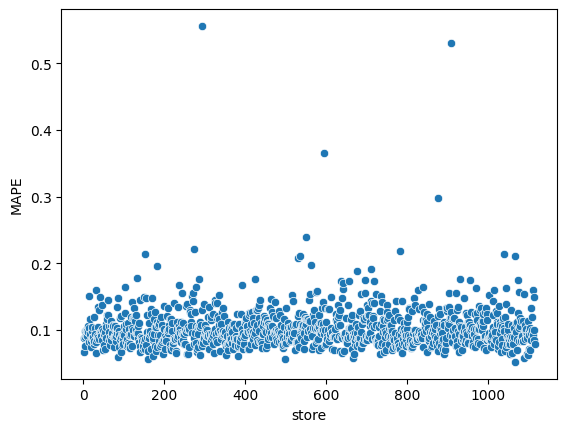

In [ ]:
sns.scatterplot(x='store', y='MAPE', data=df92)

#### Total Performance

In [142]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values' })
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)

df93

,Scenarios,Values
0,predictions,"R$ 284,555,904.00"
1,worst_scenario,"R$ 283,771,746.08"
2,best_scenario,"R$ 285,340,074.96"


#### Machine Learning Performance

In [148]:
df9.loc[:, 'error'] = df9['sales'] - df9['predictions']
df9.loc[:, 'error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipython-input-148-3909621883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.loc[:, 'error'] = df9['sales'] - df9['predictions']
/tmp/ipython-input-148-3909621883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.loc[:, 'error_rate'] = df9['predictions'] / df9['sales']


<Axes: xlabel='predictions', ylabel='error'>

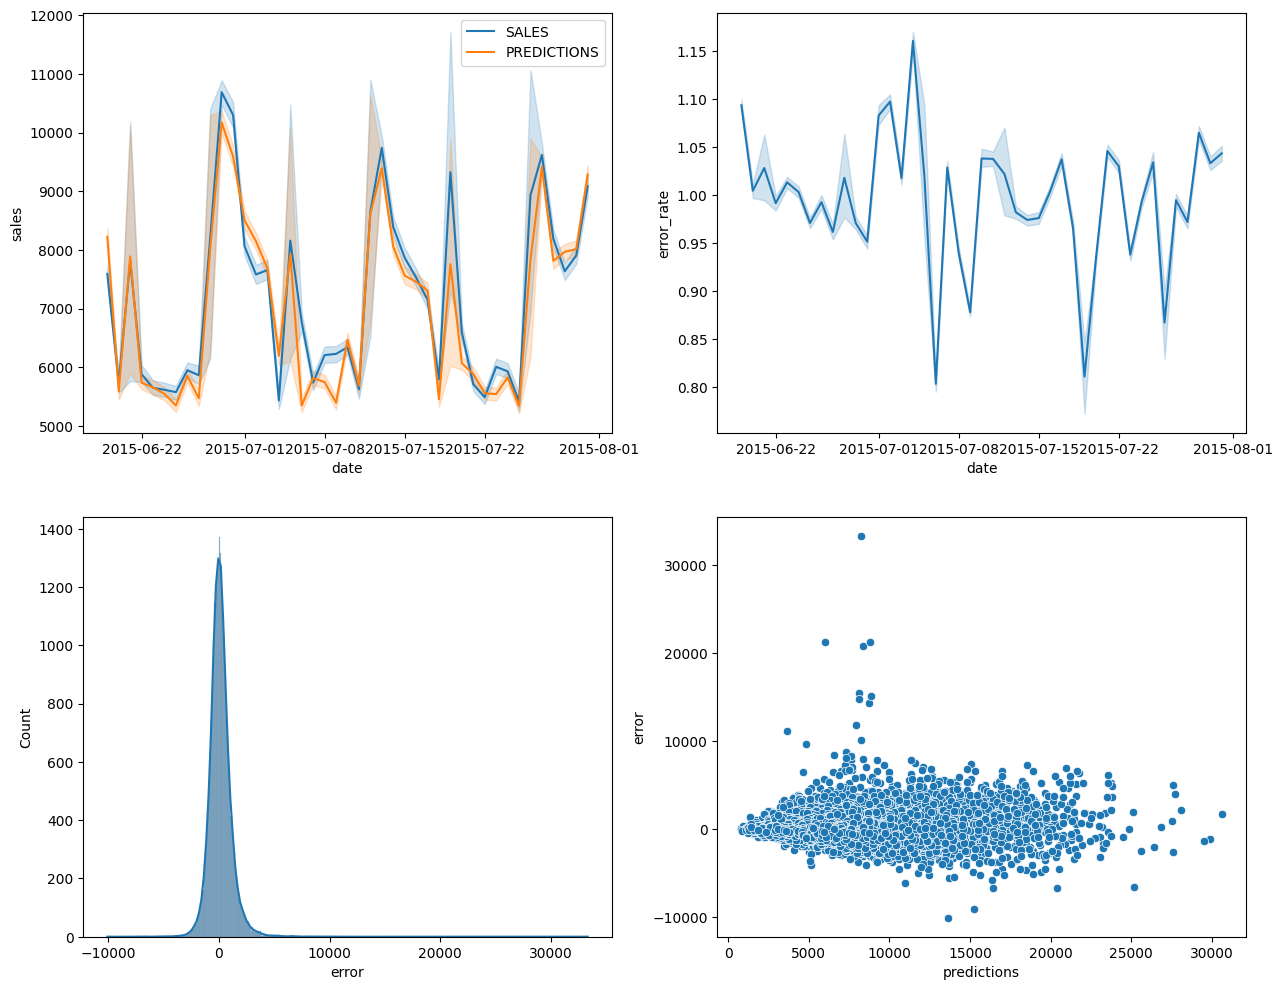

In [154]:
plt.figure(figsize=(15, 12))


plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.histplot(df9['error'], kde=True)

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error', data=df9)

## Deploy model for Production

#### Export best Model

In [116]:
pickle.dump(final_model, open('model_rossman.pkl', 'wb'))

In [17]:
print(xgb.__version__)

3.0.2


#### API Tester

In [117]:
import pandas as pd
import os
import pandas as pd

# Caminho até a pasta raiz do projeto (ajuste se o notebook estiver em outra subpasta)
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'projeto rossman', '..', '..'))
dataset_path = os.path.join(ROOT_PATH, 'datasets', 'test.csv')

df10 = pd.read_csv(dataset_path)

In [118]:
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test.loc[df_test['Store'].isin([24])]

#remove closed days
df_test = df_test.loc[df_test['Open'] != 0]
df_test = df_test.loc[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [119]:
import json

#convert to json
data = json.dumps(df_test.to_dict(orient='records'), default=str)

In [121]:
import requests

url = 'https://hossman-model-prediction-315aed2b5d3b.herokuapp.com/rossman/predict'
headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=data, headers=headers)  # <-- use json= aqui
print('Status Code:', r.status_code)

Status Code: 200


In [122]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [123]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the nest 6 weeks'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction']))

Store Number 24 will sell R$263,425.38 in the nest 6 weeks


In [42]:
d2

,store,prediction
0,22,169780.356201
